<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/FFN_scrambledMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [13]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [14]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)


(20000,)
(20000, 784)


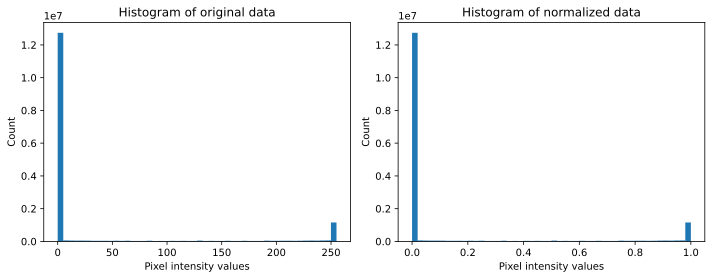

In [15]:
#normalize the data to a range of [0 1]
dataNorm=data/np.max(data)
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
plt.tight_layout()
plt.show()

Scramble the images


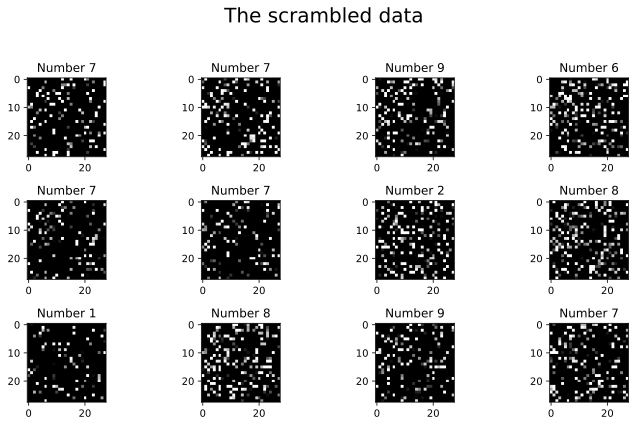

In [16]:
#randomly scramble the data,
#preserving the re-ordering for each image
eggs=np.random.permutation(data.shape[1])
scrambled=dataNorm[:,eggs]
#show a few random digits
fig,axs=plt.subplots(3,4,figsize=(10,6))
for ax in axs.flatten():
  randimg2show=np.random.randint(0,high=data.shape[0])
  #create the image(must be reshaped!)
  img=np.reshape(scrambled[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')
  #title
  ax.set_title('Number %i'%labels[randimg2show])
plt.suptitle('The scrambled data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

Create train/TEST GROUPS USING DataLoader

In [17]:
# Step 1: convert to tensor
dataT   = torch.tensor( scrambled ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [18]:
#check all variables in workspace
%whos

Variable            Type             Data/Info
----------------------------------------------
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                  Axes             Axes(0.813982,0.064537;0.109611x0.182685)
axs                 ndarray          3x4: 12 elems, type `object`, 96 bytes
batchsize           int              32
createTheMNISTNet   function         <function createTheMNISTNet at 0x7f79cee3fe20>
data                ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm            ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT               Tensor           tensor([[0.0000, 0.0000, <...>0.0000, 0.0000, 0.0000]])
eggs                ndarray          784:

Create the DL model

In [19]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,64)
      ###hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      ###output layer
      self.output = nn.Linear(32,10)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet()
  #loss function
  lossfun = nn.CrossEntropyLoss()
  #optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun, optimizer

Create a function that trains the model

In [20]:
# a function that trains the model
def function2trainTheModel():
  #number of epocs
  numepochs=100
  #create a new model
  net,lossfun,optimizer=createTheMNISTNet()
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Run the model and show the results

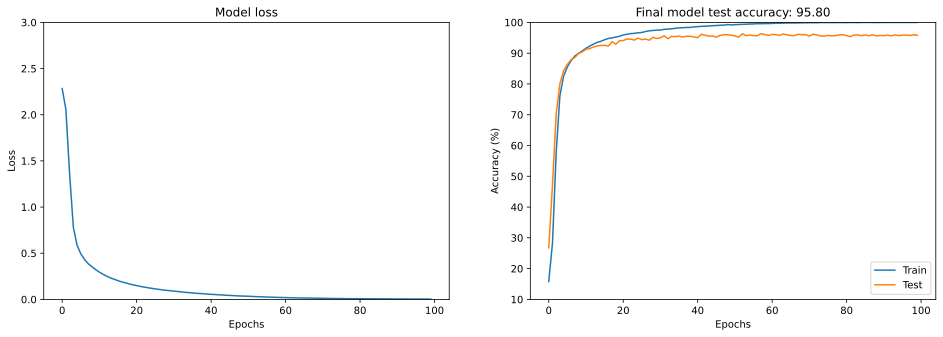

In [21]:
trainAcc, testAcc,losses, net=function2trainTheModel()
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}')
ax[1].legend()
plt.show()

Inspect the results in more detail

In [25]:
X,y=next(iter(test_loader))
predictions=net(X).detach()
predictions

tensor([[-22.8828,  19.2517,  -1.8392,  ...,   8.9034,   4.2613,   3.5163],
        [  2.2636, -17.0758, -11.7005,  ..., -15.3941,  13.2127,  13.0185],
        [-16.7045,  20.8912,   4.2872,  ...,   7.8420,   7.5907,  -5.8734],
        ...,
        [ -1.4585,  -6.3945, -10.4485,  ...,  -6.2868,  10.5534,  10.3669],
        [-14.4409,  13.9088,  -2.3929,  ...,   5.8436,   2.9231,   2.5175],
        [-14.2253,  11.3000,  -0.2871,  ...,  -5.4973,   8.5850,   8.9578]])

<ipython-input-26-9d383132a6fc>:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.bar(range(10),np.exp(predictions[sample2show]))


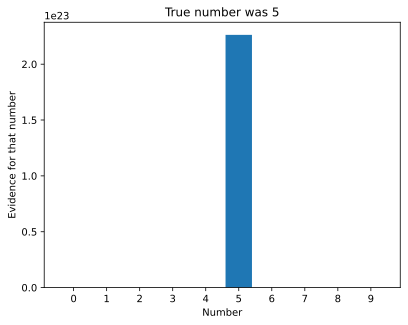

In [26]:
#evidence for all numbers from one sample
sample2show=120
plt.bar(range(10),np.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title("True number was %s"%y[sample2show].item())
plt.show()

[  44   91   98   99  115  119  154  188  234  237  239  250  297  302
  354  368  373  378  380  448  459  470  512  530  540  545  554  569
  570  591  626  642  698  699  709  735  743  776  801  814  916  937
  985 1046 1062 1096 1112 1127 1246 1256 1267 1268 1279 1306 1320 1374
 1396 1401 1440 1493 1497 1507 1519 1525 1534 1552 1589 1605 1619 1627
 1661 1694 1756 1765 1791 1813 1838 1841 1879 1932 1933 1941 1945 1959]


<ipython-input-24-605ba88b614e>:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))


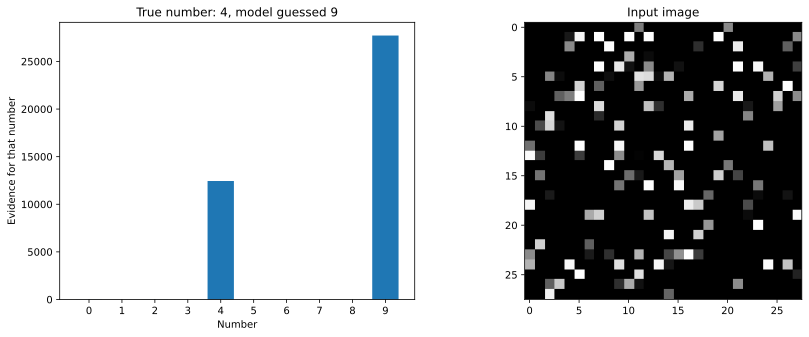

In [24]:
from typing import ChainMap
#find the errors
errors=np.where(torch.argmax(predictions,axis=1)!=y)[0]
print(errors)
#Evidence for all numbers from one sample
sample2show=10
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'%(y[errors[sample2show]].item(),torch.argmax(predictions[errors[sample2show]]).item()))
ax[1].imshow(np.reshape(X[errors[sample2show],:],(28,28)),cmap='gray')
ax[1].imshow(X[errors[sample2show]].view(28,28),cmap='gray')
ax[1].set_title('Input image')
plt.show()